In [1]:
import boule as bl
import ensaio
import numpy as np
import pandas as pd
import pygmt
import verde as vd
import xarray as xr
import harmonica as hm
import scipy as scipy
from numba import njit
import matplotlib.pyplot as plt

# Load Moho & LAB and NearestNDInterpolator Function

In [2]:
# Moho                     
moho_file_path = 'moho_depth.csv'
moho_df = pd.read_csv(moho_file_path)

camlab_file_path = "D:\\Amitava\\Projects\\Perple_X\\V2RhoT_gibbs\\LAB_geoid_data\\CAM2022_lithosphere.xyz"
camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])

fname = ensaio.fetch_earth_topography(version=1)
topo = xr.load_dataarray(fname)

# Topo
topo_file_path = r"D:\Amitava\Projects\Perple_X\topo\etopo2_downsampled.csv"
topo_df = pd.read_csv(topo_file_path, usecols=['x', 'y', 'z'])
topo_df.rename(columns={'x': 'Longitude', 'y': 'Latitude', 'z': 'Topo'}, inplace=True)      # Rename columns to match interpolation logic
topo_df = topo_df[['Latitude', 'Longitude', 'Topo']]  # Reorder columns

C:\Users\DELL\AppData\Local\Temp\ipykernel_9004\1790229125.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])


In [3]:
moho_func = scipy.interpolate.NearestNDInterpolator(list(zip(moho_df['Latitude'], moho_df['Longitude'])), moho_df['Moho'])
camlab_func = scipy.interpolate.NearestNDInterpolator(list(zip(camlab_df['Latitude'], camlab_df['Longitude'])), camlab_df['Depth'])
topo_func = scipy.interpolate.NearestNDInterpolator(list(zip(topo_df['Latitude'], topo_df['Longitude'])), topo_df['Topo'])

In [4]:
#region = [west, east, south, north]
#region = [-78, -53, -57, -20] # SA
#region = [112, 155, -45, -10]  # Australia
#region = [68, 98, 6, 38]  # India
region = [-179.9, 179.9, -89.9, 89.9] # World

In [5]:
import random

# Get a random integer between 1 and 10 (inclusive)
random_integer = random.random()
print(random_integer)

0.3966777039487104


# Gravity field for different density layers

[[843824.04760718 843818.57583215 843814.47654247 ... 843839.38712189
  843831.20466906 843824.31921901]
 [847085.29165634 847094.65081614 847182.6957532  ... 847320.56268065
  847162.81181954 847086.74560329]
 [864681.78606966 865536.40103731 867078.61139233 ... 864999.02831836
  864546.74150204 864661.00046599]
 ...
 [971856.88394927 970310.87727866 969159.02415452 ... 976175.48285161
  973884.11262263 971933.86072596]
 [974588.71697465 973947.49995728 973466.29601367 ... 976368.63737898
  975421.82216721 974620.44613545]
 [986048.05316039 986025.48360104 986007.51894365 ... 986107.86432337
  986076.36841945 986049.1474962 ]]


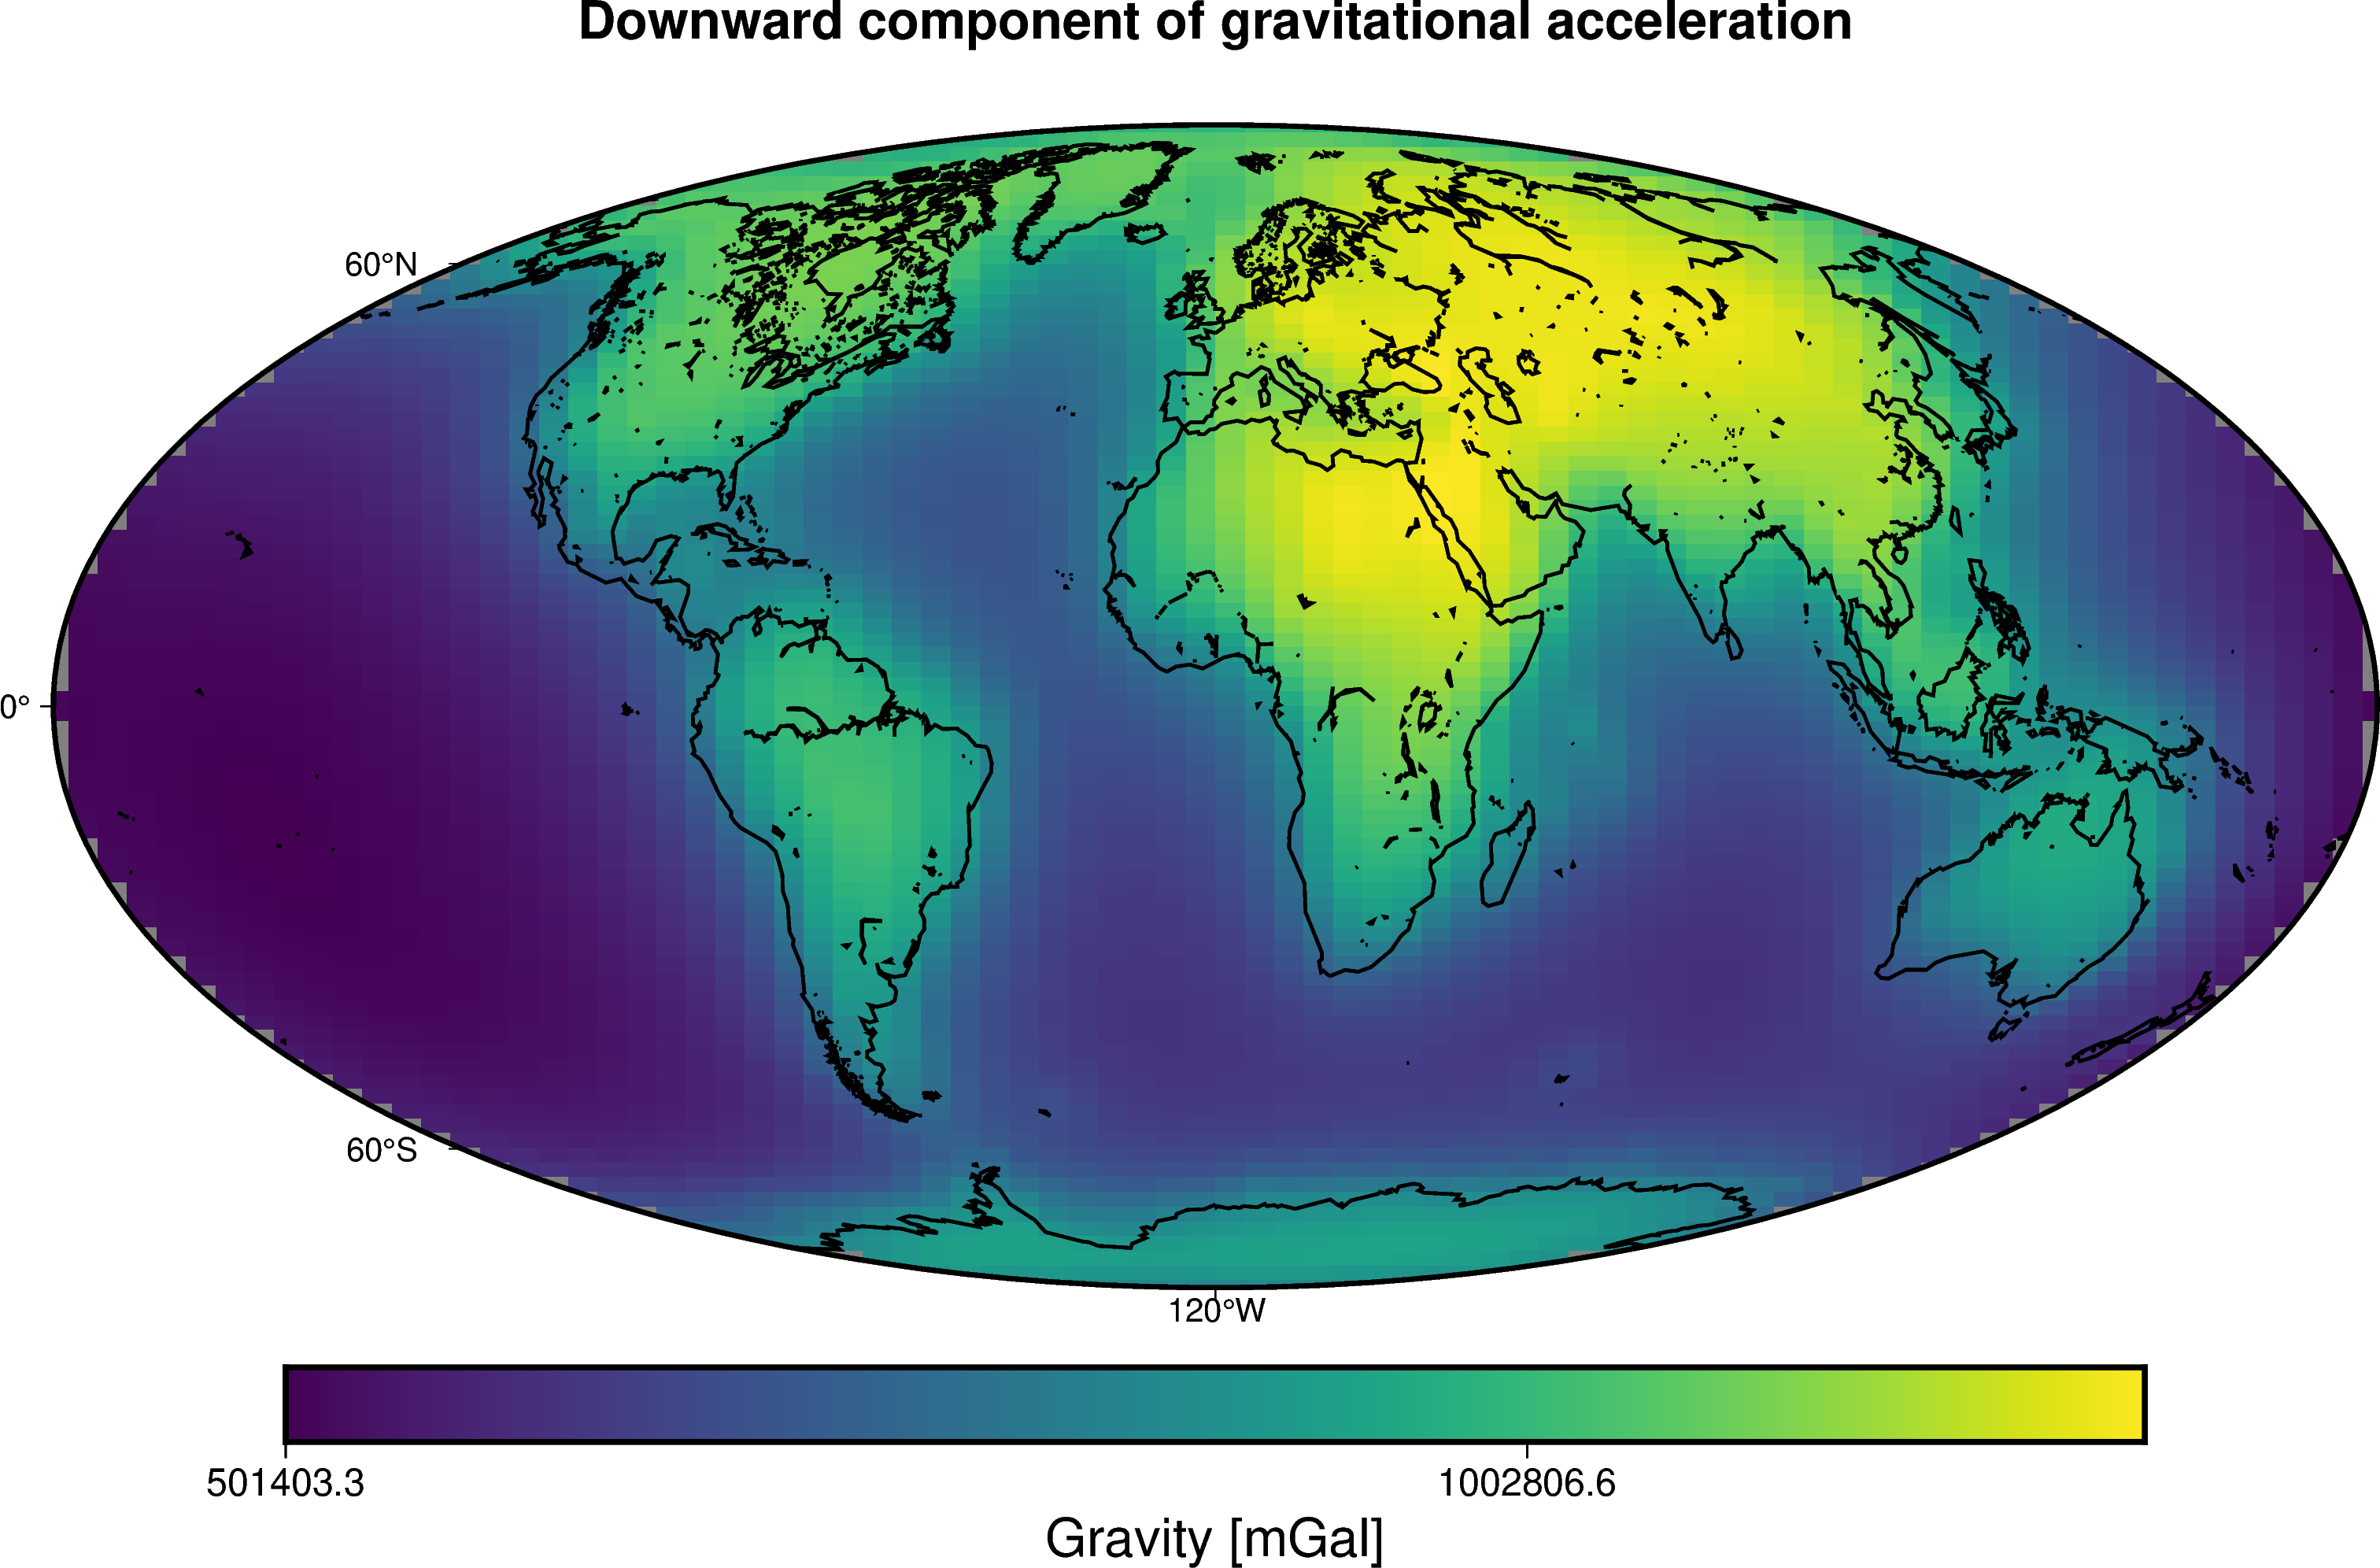

CPU times: total: 7min 29s
Wall time: 1min 15s


In [6]:
%%time
# Use the WGS84 ellipsoid to obtain the mean Earth radius which we'll use to
# reference the tesseroid
ellipsoid = bl.WGS84
mean_radius = ellipsoid.mean_radius

# Define tesseroid with top surface at the mean Earth radius, a thickness of
tesseroids = []
density = []
tess_den = []
dlong=5
dlat=5
longitude_max=175
longitude_min=-175
latitude_max=85
latitude_min=-85
depth_min = 0
depth_max = mean_radius  # ~6371e3
ddepth=100e3

for lat in np.arange(latitude_min, latitude_max,dlat):   # step of 1 degree
    for lon in np.arange(longitude_min, longitude_max,dlong):
        #depth_max = (camlab_func(lat, lon) *1e3)
        for depth in np.arange(depth_min, depth_max, ddepth):
            r_top = mean_radius - depth
            r_bottom = mean_radius - min(depth + ddepth, depth_max)
            #r_bottom = float(mean_radius - depth)
            #r_top = float(mean_radius - depth + ddepth)

            tesseroids.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top])

            # Assigning density for various layers
            topo = topo_func(lat, lon) *1e3
            moho = moho_func(lat, lon) *1e3
            lab = camlab_func(lat, lon) *1e3

            radius_mid = 0.5 * (r_top + r_bottom) #mean_radius-depth

            if topo < 0:
                # Oceanic
                if r_bottom >= mean_radius + topo:
                    rho_top, rho_bottom = 1000.0, 1040.0  # Seawater
                elif r_bottom >= mean_radius - moho:
                    rho_top, rho_bottom = 2850.0, 2950.0  # Oceanic crust
                elif r_bottom >= mean_radius - lab:
                    rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                elif r_bottom <= 660e3:
                    rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                elif r_bottom <= 2890e3:
                    rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                elif r_bottom <= 5150e3:
                    rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                else:
                    rho_top, rho_bottom = 12000.0, 13000.0  # Inner core
            else:
                # Continental
                if r_bottom >= mean_radius - moho:
                    rho_top, rho_bottom = 2670.0, 3000.0  # Continental crust
                elif r_bottom >= mean_radius - lab:
                    rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                elif r_bottom <= 660e3:
                    rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                elif r_bottom <= 2890e3:
                    rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                elif r_bottom <= 5150e3:
                    rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                else:
                    rho_top, rho_bottom = 12000.0, 13000.0  # Inner core

            # Linear profile
            slope = (rho_top - rho_bottom) / (r_top - r_bottom)
            density_mid = slope * (radius_mid - r_bottom) + rho_bottom
            density.append(density_mid)
            tess_den.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])

coordinates = vd.grid_coordinates(region=region,shape=(80, 80),extra_coords=100e3 + ellipsoid.mean_radius,)

# Compute the radial component of the acceleration
gravity = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")
print(gravity)
grid = vd.make_xarray_grid(coordinates, gravity, data_names="gravity", extra_coords_names="extra")

# Plot the gravitational field
fig = pygmt.Figure()

title = "Downward component of gravitational acceleration"

with pygmt.config(FONT_TITLE="16p"):
    fig.grdimage(region=region,projection="W25c",grid=grid.gravity,frame=["a", f"+t{title}"],cmap="viridis",)
    
vmin = float(grid.gravity.min())
vmax = float(grid.gravity.max())

fig.colorbar(cmap=True,frame=[f"x+lGravity [mGal]",f"a{vmin:.1f},{vmin:.1f},{vmax:.1f}"])
fig.coast(shorelines="1p,black")

fig.show()

In [7]:
np.shape(np.arange(latitude_min, latitude_max,dlat)),np.shape(np.arange(longitude_min, longitude_max,dlong)),np.shape(np.arange(depth_max,depth_min,-ddepth))

((34,), (70,), (64,))

In [8]:
print("Min gravity:", gravity.min())
print("Max gravity:", gravity.max())

Min gravity: 501403.2580534374
Max gravity: 1252286.3326382537


In [9]:
np.shape(gravity)

(80, 80)

In [10]:
tesseroids = np.array(tesseroids)
density = np.array(density) 
tess_den = np.array(tess_den) 

In [11]:
np.shape(tesseroids)

(152320, 6)

In [12]:
np.shape(tess_den)

(152320, 7)

In [13]:
tess_den

array([[-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.27099440e+06,  6.37099440e+06,  3.30000000e+03],
       [-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.17099440e+06,  6.27099440e+06,  1.25000000e+04],
       [-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.07099440e+06,  6.17099440e+06,  1.25000000e+04],
       ...,
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         1.70994402e+05,  2.70994402e+05,  3.92500000e+03],
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         7.09944018e+04,  1.70994402e+05,  3.92500000e+03],
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         0.00000000e+00,  7.09944018e+04,  3.92500000e+03]])

In [14]:
np.shape(tess_den)

(152320, 7)

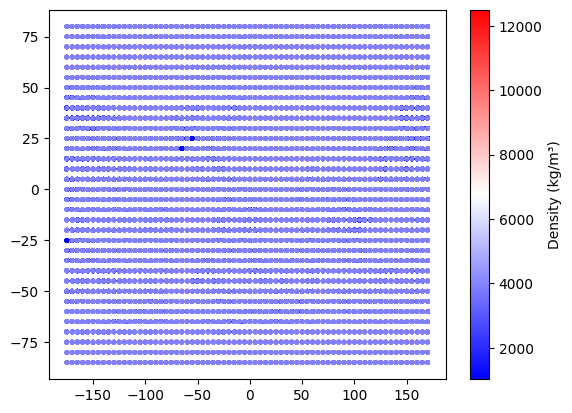

In [15]:
plt.scatter(tess_den[:, 0], tess_den[:, 2], c=tess_den[:, 6], cmap='bwr', s=5)
plt.colorbar(label="Density (kg/m³)")

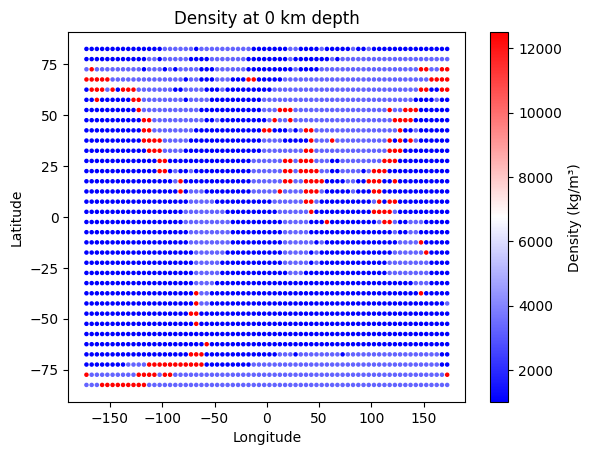

In [16]:
depth_target = 0.1e3  # 40 km depth
radius_target = mean_radius - depth_target
mask = (tess_den[:, 4] <= radius_target) & (tess_den[:, 5] >= radius_target)
subset = tess_den[mask]
lon_center = 0.5 * (subset[:, 0] + subset[:, 1])
lat_center = 0.5 * (subset[:, 2] + subset[:, 3])
density = subset[:, 6]
plt.scatter(lon_center, lat_center, c=density, cmap='bwr', s=5)
plt.title(f"Density at {depth_target/1e3:.0f} km depth")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Density (kg/m³)")
plt.show()

In [17]:
all_depths = mean_radius - tess_den[:, 4:6]
print(f"Depth range: {np.min(all_depths):.1f} km to {np.max(all_depths):.1f} km")


Depth range: 0.0 km to 6370994.4 km


In [18]:
print("First few r_bottom values:", tess_den[:5, 4])
print("Should be ~6,000,000 (not hundreds of thousands)")

First few r_bottom values: [6270994.40182758 6170994.40182758 6070994.40182758 5970994.40182758
 5870994.40182758]
Should be ~6,000,000 (not hundreds of thousands)


In [19]:
grid

<xarray.Dataset> Size: 104kB
Dimensions:   (northing: 80, easting: 80)
Coordinates:
  * easting   (easting) float64 640B -179.9 -175.3 -170.8 ... 170.8 175.3 179.9
  * northing  (northing) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
    extra     (northing, easting) float64 51kB 6.471e+06 6.471e+06 ... 6.471e+06
Data variables:
    gravity   (northing, easting) float64 51kB 8.438e+05 8.438e+05 ... 9.86e+05

In [39]:
# Rename dimensions and coordinates
grid_rename = grid.rename({
    "northing": "latitude",
    "easting": "longitude"
})

# Extract and rename gravity
observed_gravity = grid_rename["gravity"].rename("observed_gravity")

# Include the height/radius as a coordinate
observed_gravity = observed_gravity.assign_coords(
    height=grid_rename["extra"]
)

# Sort for CF compliance
observed_gravity = observed_gravity.sortby(["latitude", "longitude"])

# Set attributes
observed_gravity.attrs.update({
    "units": "mGal",
    "long_name": "gravity acceleration",
    "description": "observed gravitational acceleration at Earth's surface",
    "crs": "WGS84",
    "Conventions": "CF-1.8",
    "title": "Observed gravity field",
})

# Optional: add attributes to the height coordinate
observed_gravity.coords["height"].attrs.update({
    "units": "m",
    "long_name": "height above reference ellipsoid",
    "standard_name": "height",
    "positive": "up"
})


In [40]:
observed_gravity

<xarray.DataArray 'observed_gravity' (latitude: 80, longitude: 80)> Size: 51kB
array([[843824.04760718, 843818.57583215, 843814.47654247, ...,
        843839.38712189, 843831.20466906, 843824.31921901],
       [847085.29165634, 847094.65081614, 847182.6957532 , ...,
        847320.56268065, 847162.81181954, 847086.74560329],
       [864681.78606966, 865536.40103731, 867078.61139233, ...,
        864999.02831836, 864546.74150204, 864661.00046599],
       ...,
       [971856.88394927, 970310.87727866, 969159.02415452, ...,
        976175.48285161, 973884.11262263, 971933.86072596],
       [974588.71697465, 973947.49995728, 973466.29601367, ...,
        976368.63737898, 975421.82216721, 974620.44613545],
       [986048.05316039, 986025.48360104, 986007.51894365, ...,
        986107.86432337, 986076.36841945, 986049.1474962 ]])
Coordinates:
  * longitude  (longitude) float64 640B -179.9 -175.3 -170.8 ... 175.3 179.9
  * latitude   (latitude) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
    extra      (latitude, longitude) float64 51kB 6.471e+06 ... 6.471e+06
    height     (latitude, longitude) float64 51kB 6.471e+06 ... 6.471e+06
Attributes:
    units:        mGal
    long_name:    gravity acceleration
    description:  observed gravitational acceleration at Earth's surface
    crs:          WGS84
    Conventions:  CF-1.8
    title:        Observed gravity field

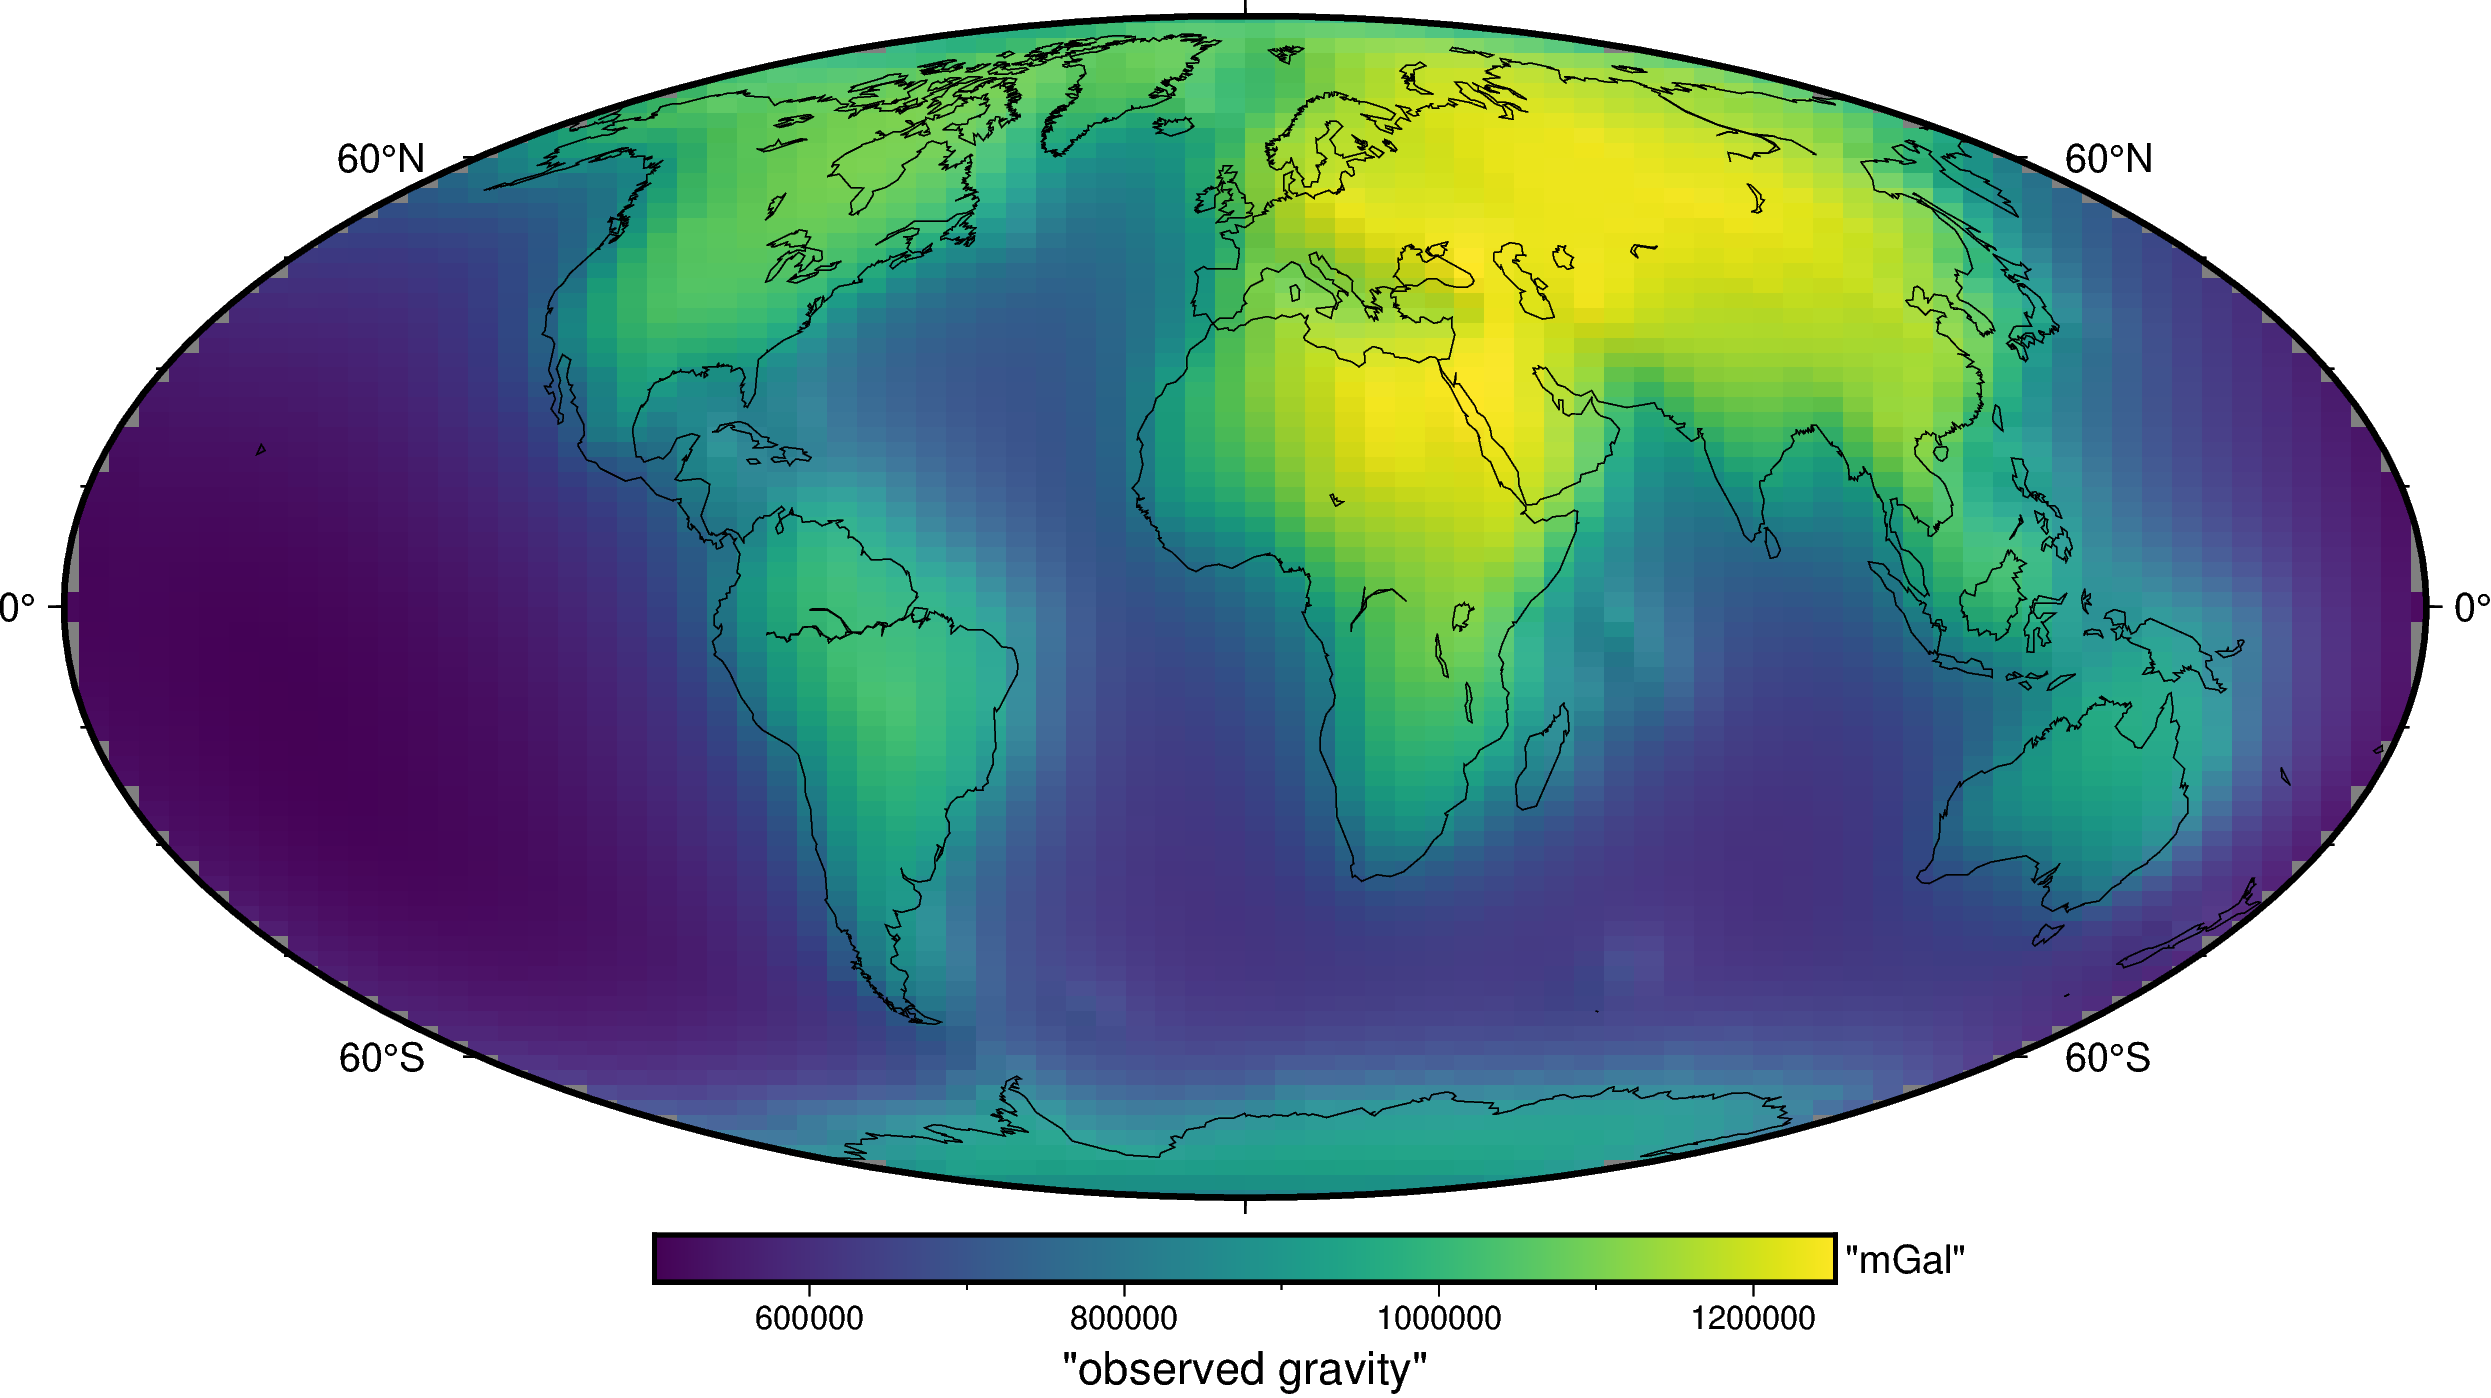

In [41]:
fig = pygmt.Figure()
fig.grdimage(
    observed_gravity,
    projection="W20c",
    cmap="viridis",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"observed gravity"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [42]:
normal_gravity = ellipsoid.normal_gravity(observed_gravity.latitude, observed_gravity.height)

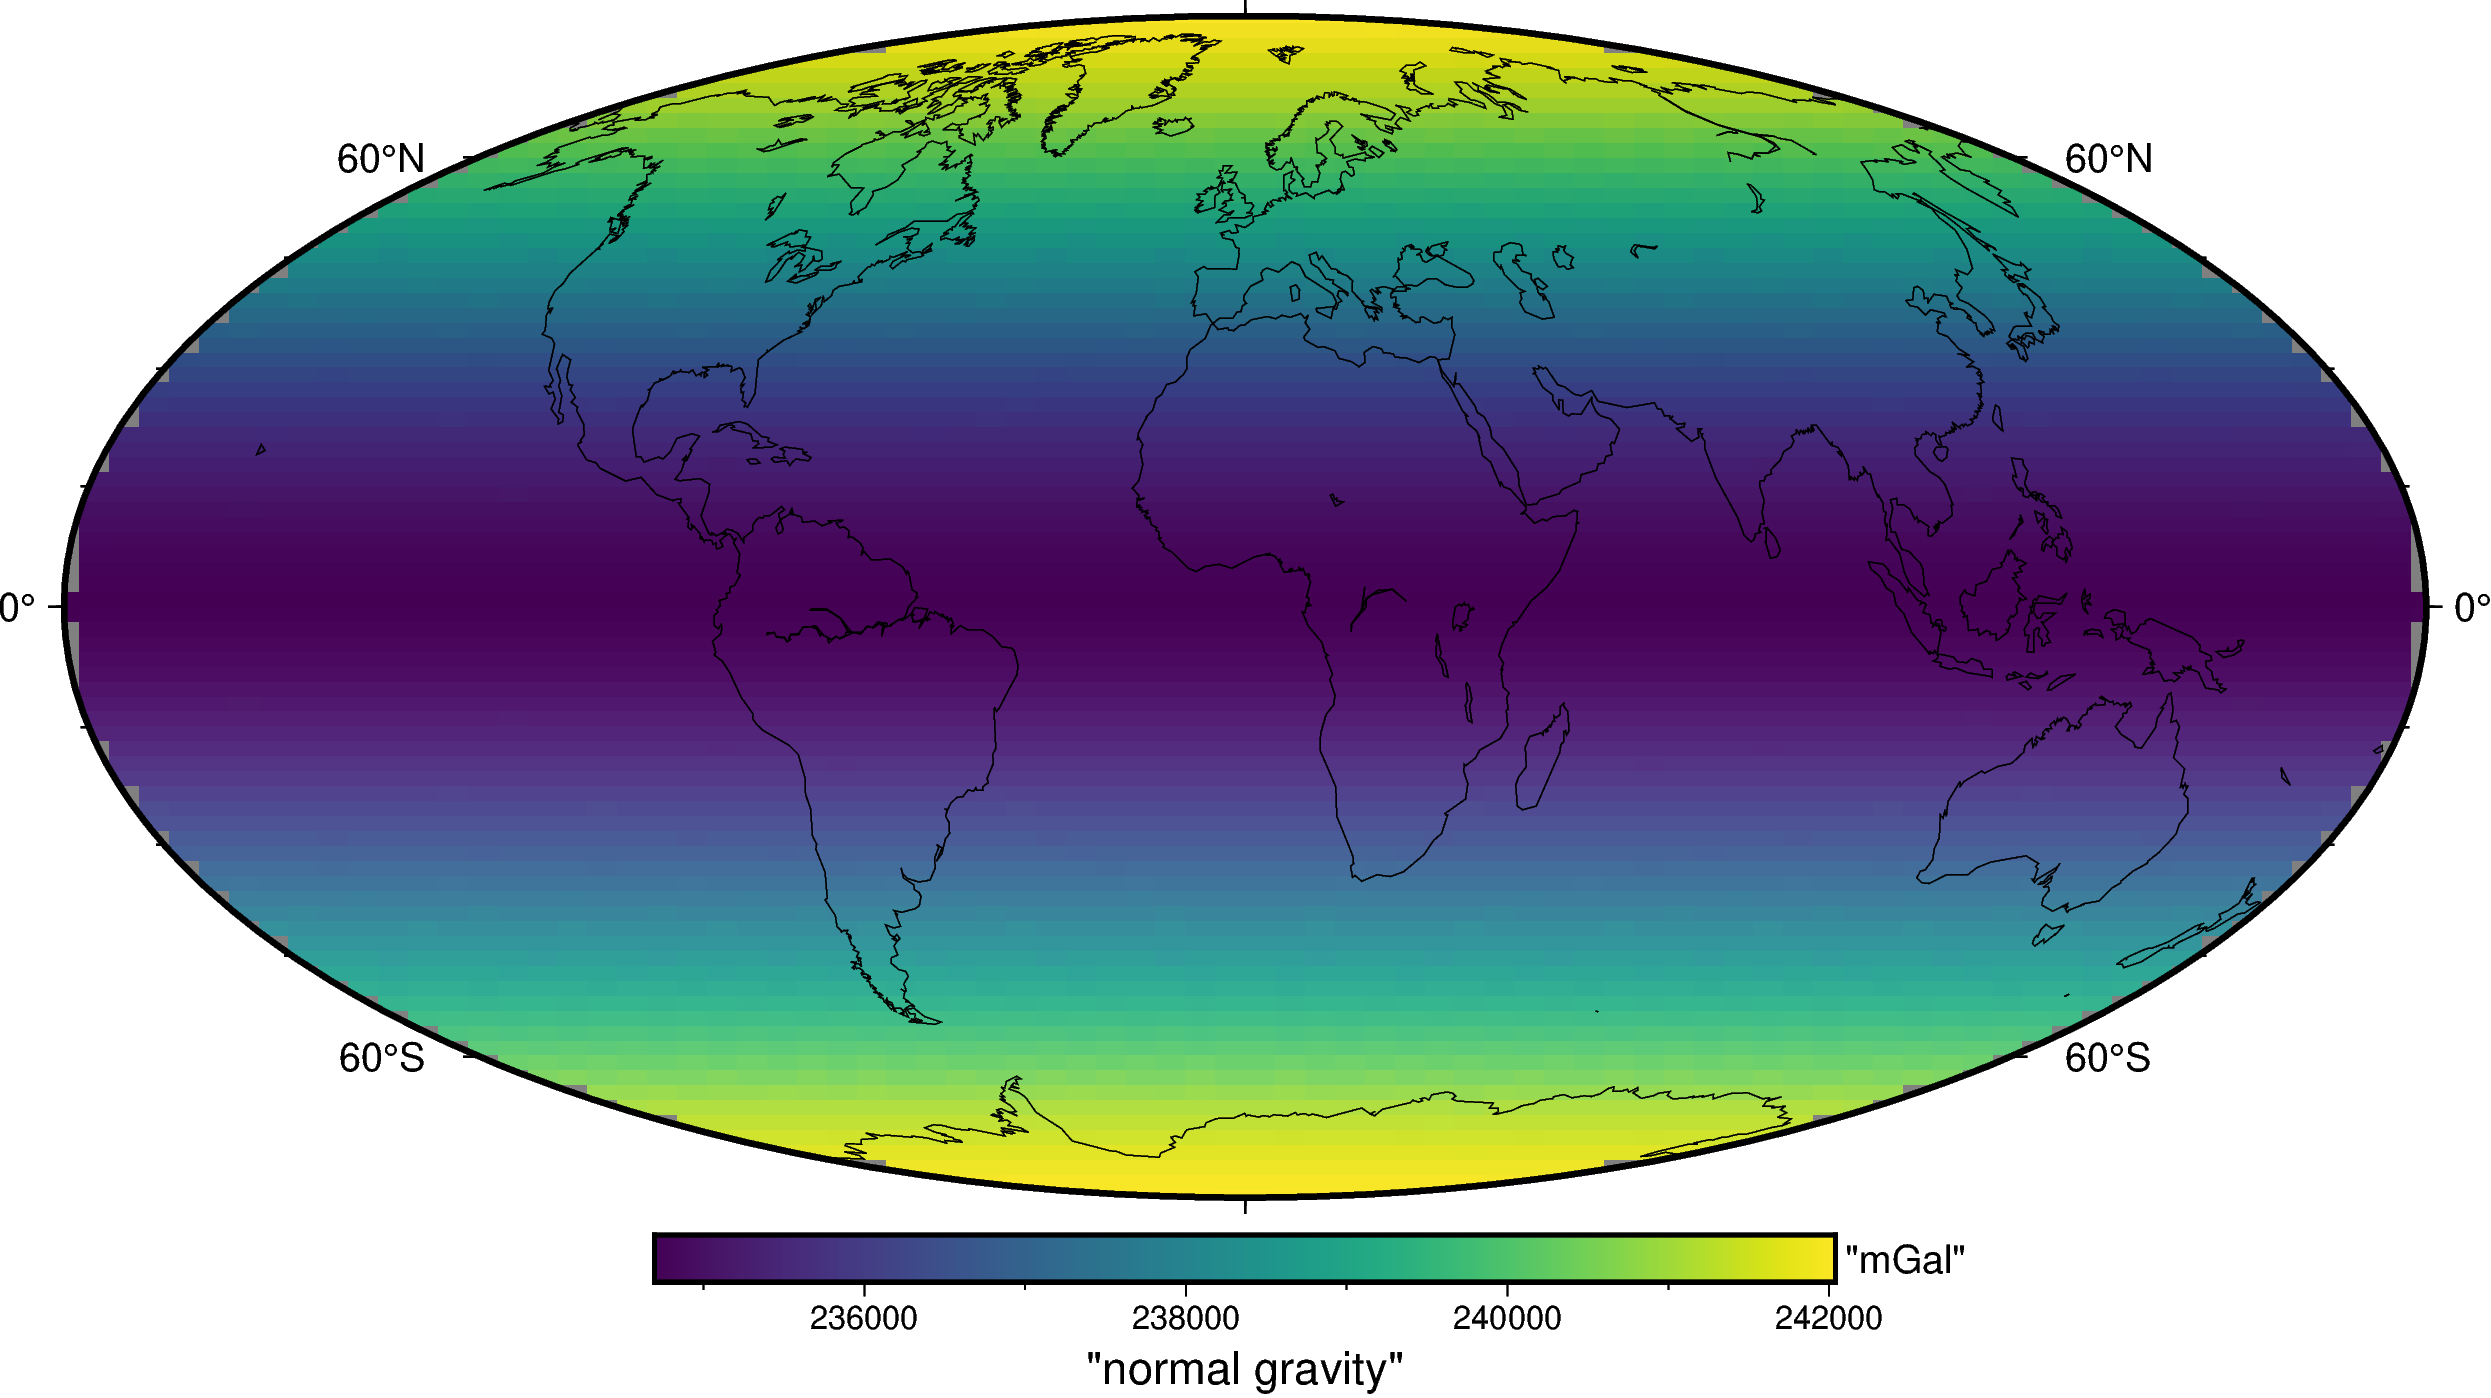

In [43]:
fig = pygmt.Figure()
fig.grdimage(
    normal_gravity,
    projection="W20c",
    cmap="viridis",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"normal gravity"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [44]:
gravity_disturbance = gravity - normal_gravity
print(gravity_disturbance)


<xarray.DataArray (latitude: 80, longitude: 80)> Size: 51kB
array([[601783.3248504 , 601777.85307536, 601773.75378568, ...,
        601798.6643651 , 601790.48191227, 601783.59646222],
       [605057.21780183, 605066.57696162, 605154.62189868, ...,
        605292.48882613, 605134.73796502, 605058.67174877],
       [622689.53579485, 623544.1507625 , 625086.36111752, ...,
        623006.77804355, 622554.49122723, 622668.75019118],
       ...,
       [729864.63367446, 728318.62700385, 727166.77387971, ...,
        734183.2325768 , 731891.86234782, 729941.61045115],
       [732560.64312014, 731919.42610276, 731438.22215916, ...,
        734340.56352446, 733393.74831269, 732592.37228093],
       [744007.33040361, 743984.76084426, 743966.79618686, ...,
        744067.14156659, 744035.64566266, 744008.42473941]])
Coordinates:
  * latitude   (latitude) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
  * longitude  (longitude) float64 640B -179.9 -175.3 -170.8 ... 175.3 179.9
    extra    

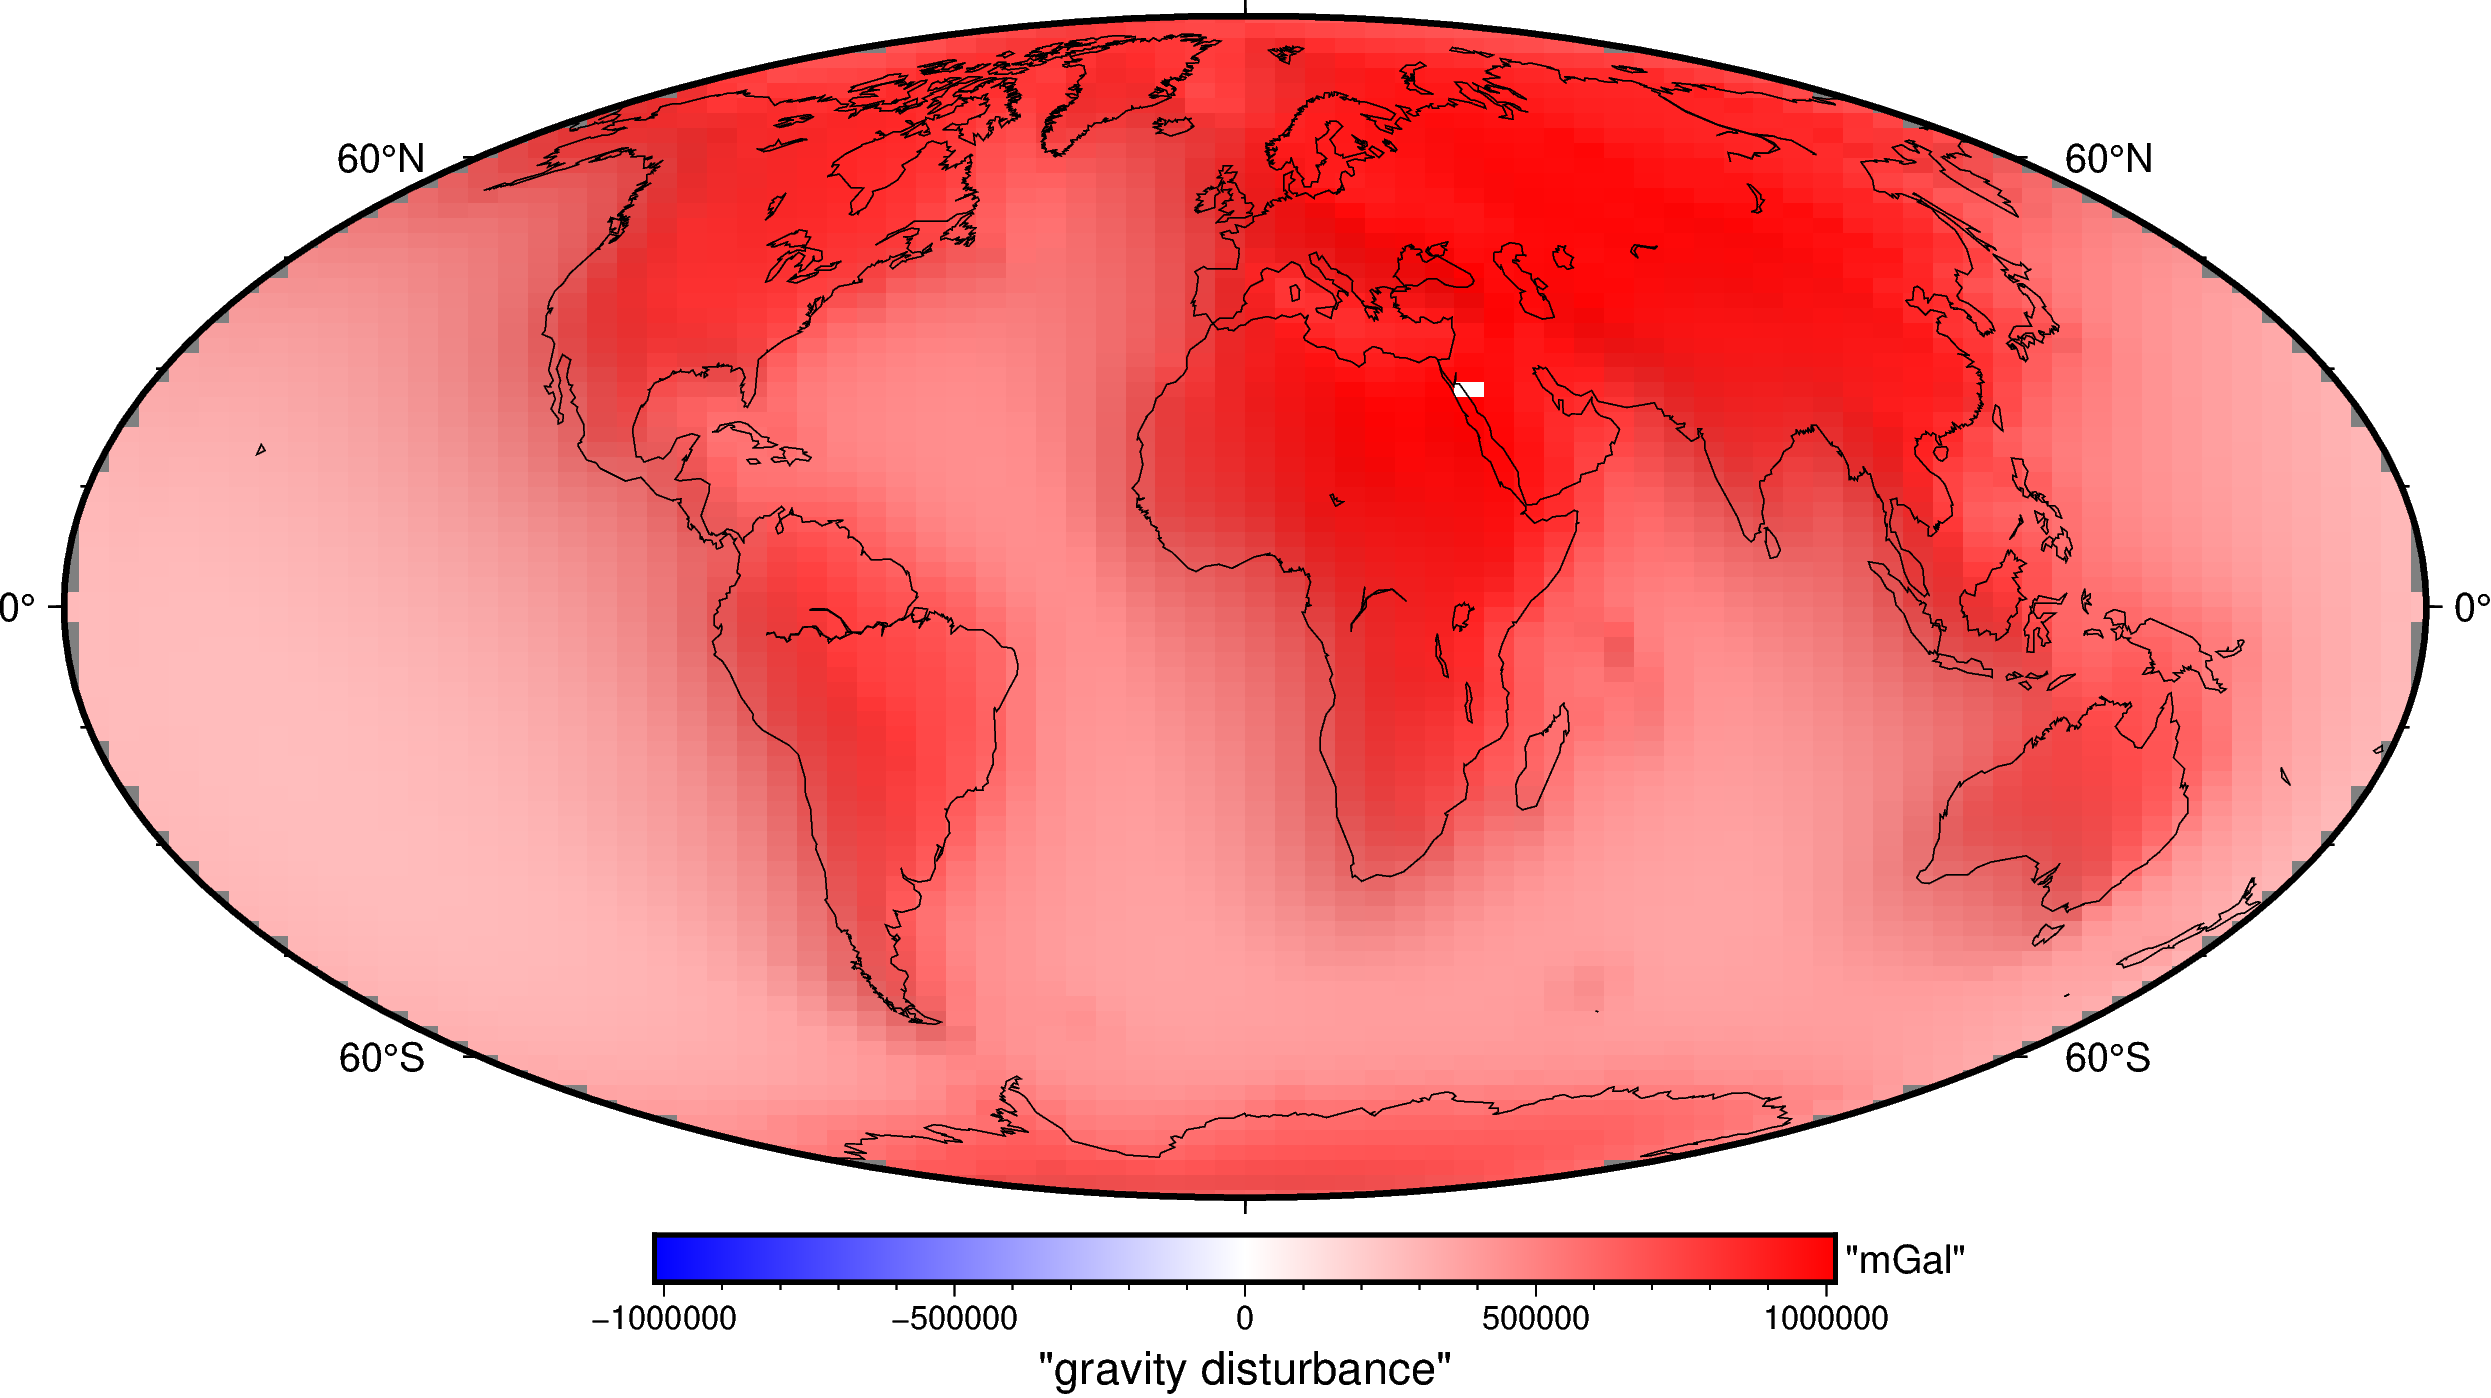

In [45]:
maxabs = vd.maxabs(gravity_disturbance)

fig = pygmt.Figure()
pygmt.makecpt(series=[-maxabs, maxabs], cmap="polar+h")
fig.grdimage(
    gravity_disturbance,
    projection="W20c",
    cmap=True,
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"gravity disturbance"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()